# DM-34356 rotation test

## Simulate elongated object and a star with diffraction spikes on the boresight. Test the behavior when using different rotation angle combinations:


Owner: **Chris Suberlak** ([@suberlak](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@suberlak))
<br>Last Verified to Run: **2022-04-06**
<br>Software Versions:
  - `ts_wep`: **v2.3.4**
  - `lsst_distrib`: **w_2022_14**
  
## Goal
Explore different test cases: 

case 1

    rotSkyPos  0 , rotTelPos 0
    rotSkyPos 30 , rotTelPos 0
    rotSkyPos 60 , rotTelPos 0

case 2

    rotSkyPos 0 , rotTelPos 30
    rotSkyPos 0 , rotTelPos 60

case 3

    rotSkyPos 0 , no rotTelPos
    rotSkyPos 30, no rotTelPos
    rotSkyPos 60, no rotTelPos

case 4

    no rotSkyPos, rotTelPos 0
    no rotSkyPos, rotTelPos 30
    no rotSkyPos, rotTelPos 60


## Setup:
    
   * access to NCSA lsst-devl nodes 
   * working installation of ts_wep package ( see the following [notes](https://confluence.lsstcorp.org/display/LTS/Onboarding+to+LSST+AOS) for additional info on how to install and build the AOS packages)
   



In [1]:
import os
import shutil
from lsst.ts.wep.Utility import runProgram
import astropy.io.ascii
import numpy as np
from lsst.daf import butler as dafButler

import sys
sys.path.append('/project/scichris/aos/rotation_DM-34065/')
import test02_runZk as tools 
import imp
imp.reload(tools)

<module 'test02_runZk' from '/project/scichris/aos/AOS/test02_runZk.py'>

In [39]:
def repackageImages(outputImgDir, instName="comcam",  defocalDistInMm=0
):
    """Repackage the images of piston camera (ComCam and LSST FAM) from
    PhoSim for processing.
    FAM: Full-array mode.
    Parameters
    ----------
    instName : `str`
        Instrument name.
    isEimg : bool, optional
        Is eimage or not. (the default is False.)
    """

    # Make a temporary directory
    tmpDirPath = os.path.join(outputImgDir, "tmp")
    if not os.path.exists(tmpDirPath):
        os.makedirs(tmpDirPath)

    focalDirName = "focus"
    
    # Repackage the images to the temporary directory
    command = "phosim_repackager.py"
    phosimImgDir = os.path.join(outputImgDir, focalDirName)
    argstring = "%s --out_dir=%s" % (phosimImgDir, tmpDirPath)
    argstring += f" --inst {instName} "

    focusz = defocalDistInMm * 1e3
    argstring += f" --focusz {focusz}"

    runProgram(command, argstring=argstring)

    # Remove the image data in the original directory
    argstring = "-rf %s/*.fits*" % phosimImgDir
    runProgram("rm", argstring=argstring)

    # Put the repackaged data into the image directory
    argstring = "%s/*.fits %s" % (tmpDirPath, phosimImgDir)
    runProgram("mv", argstring=argstring)

    # Remove the temporary directory
    shutil.rmtree(tmpDirPath)
    
def ingestData(
    butlerRootPath,
    outputImgDir,
    seqNumFocus,
    instName="comcam",
):
    """Ingest data into a gen3 data Butler.
    Parameters
    ----------
    butlerRootPath : str
        Path to the butler repository.
    instName : str
        Instrument name.
    """

    focusRawExpDir = os.path.join(outputImgDir, "focus")

    runProgram(f"butler ingest-raws {butlerRootPath} {focusRawExpDir}")
    
    cmd = f"butler define-visits {butlerRootPath} lsst.obs.lsst.LsstComCam"
    cmd += f' --where "exposure.seq_num IN ({seqNumFocus})"'
    runProgram(cmd)

  
def writeIsrConfiguration(instName, pipelineYamlPath):
    """Write ISR pipeline task configuration.
    Parameters
    ----------
    instName: `str`
        Name of the instrument this configuration is intended for.
    pipelineYamlPath: `str`
        Path where the pipeline task configuration yaml file
        should be saved.
    """

    butlerInstName = "ComCam" if instName == "comcam" else "Cam"

    with open(pipelineYamlPath, "w") as fp:
        fp.write(
            f"""# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.Lsst{butlerInstName}
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
      # Below we specify the configuration settings we want to use
      # when running the task in this pipeline. Since our data doesn't
      # include bias or flats we only want to use doApplyGains and
      # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
"""
        )


def runIsr(obsId, butlerRootPath, instName="comcam", numPro=20):
    """Run ISR pipeline task.
    Parameters
    ----------
    extraObsId : `int`
        Extra observation id.
    intraObsId : `int`
        Intra observation id.
    butlerRootPath : `str`
        Path to the butler gen3 repos.
    instName : `str`
        Instrument name.
    numPro : int, optional
        Number of processor to run DM pipeline. (the default is 1.)
    Returns
    -------
    listOfWfErr : `list` of `SensorWavefrontError`
        List of SensorWavefrontError with the results of the wavefront
        estimation pipeline for each sensor.
    """
    visitIdOffset = 4021114100000
    butlerInstName = "ComCam" if instName == "comcam" else "Cam"
    pipelineYaml = f"{instName}Pipeline.yaml"
    pipelineYamlPath = os.path.join(butlerRootPath, pipelineYaml)

    butler = dafButler.Butler(butlerRootPath)

    if f"LSST{butlerInstName}/calib" not in butler.registry.queryCollections():

        print("Ingesting curated calibrations.")

        runProgram(
            f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.Lsst{butlerInstName}"
        )

    writeIsrConfiguration(instName, pipelineYamlPath)

    runProgram(
        f"pipetask run -b {butlerRootPath} "
        f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "
        f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "
        f"--register-dataset-types --output-run ts_phosim_{obsId} -p {pipelineYamlPath} -d "
        f'"exposure IN ({visitIdOffset+obsId})" -j {numPro} --clobber-outputs'
    )


To simulate a galaxy, use information in https://bitbucket.org/phosim/phosim_release/wiki/PhoSimTutorial_11 , eg 
    
    object 0 0.0 0 16 ../sky/sed_flat.txt 0 0 0 0 0 0 sersicDiskComplex 5.0 5.0 1.0 0.0 60.0 0.0 1.0 0.2 1000 1.0 1.0 20.0 10.0 1.0 0.0 none none



I make one repo for stars (`test02_d` ) another repo for  galaxies `test02_dg` , just to test it out .. The names of cmd and inst files still have `star`, I'll change it later 

In [40]:
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_dg'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butlerFilePath = os.path.join(butlerRootPath, "butler.yaml")

# only run once
if not os.path.exists(butlerFilePath):
    # generate butler gen3 repo and refCat once
    tools.generateButler(butlerRootPath)

In [41]:
import imp
imp.reload(tools)

<module 'test02_runZk' from '/project/scichris/aos/AOS/test02_runZk.py'>

In [68]:
# bookkeeping - all in the same repo, but simulated in different directories 
testCase = 4

#rotSkyPos = ''
rotTelPos=''
for rotSkyPos in [0, 30, 60]: 

    sensorName = "R22_S11"
    numPro = 30
    objType= 'galaxy'#  'star' # 'galaxy'
    mag = 17
    defocal = "Focus"

    titleDeg = f"rs-{rotSkyPos}_rt-{rotTelPos}"
    rotTestDir = os.path.join(baseOutputDir, titleDeg)
    pertDir = os.path.join(rotTestDir, "pert")
    imageDir = os.path.join(rotTestDir, "img")

    obsId = int(f"90{testCase}{str(rotSkyPos).zfill(2)}{str(rotTelPos).zfill(2)}")
    print(f"testCase={testCase}, rotSkyPos={rotSkyPos}, rotTelPos={rotTelPos}, obsId={obsId}" )

    #obsId # we're simulating only one set of in-focus objects...

    seqNumFocus= int(str(obsId)[-5:])

    print(f"seqNumFocus={seqNumFocus}, ")

    if not os.path.exists(pertDir):
        os.makedirs(pertDir)

    # write inst file 
    instFilePath = tools.writeInstFile(
            pertDir,
            obsId=obsId,
            dof=0,
            defocal=defocal,
            rotTelPos=rotTelPos,
            rotSkyPos=rotSkyPos,
            mag = mag, 
            objType=objType)

    # write cmd file
    cmdFilePath = tools.writeCmdFile(pertDir, zernikeNumber=0)

    # get phosim args
    argString = tools.getPhosimArgs(
        imageDir,
        instFilePath=instFilePath,
        cmdFilePath=cmdFilePath,
        defocal=defocal,
        instrument="comcam",
        e2ADC=1,
        sensorName=sensorName,
        numPro=numPro,)
    #print(argString)

    # run phoSim
    tools.runPhoSim(argString)  

    # Repackage the images based on the image type
    repackageImages(outputImgDir=imageDir)

    # Ingest images into butler gen3
    ingestData(
        butlerRootPath=butlerRootPath,
        outputImgDir=imageDir,
        seqNumFocus=seqNumFocus,
                )

    # run just ISR
    runIsr(obsId, butlerRootPath, instName="comcam", numPro=numPro)

    print('Done')

testCase=4, rotSkyPos=0, rotTelPos=, obsId=9040000
seqNumFocus=40000, 
Running  python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/rotation_DM-34065/test02_dg/rs-0_rt-/pert/starFocus.inst -i comcam -e 1 -c /project/scichris/aos/rotation_DM-34065/test02_dg/rs-0_rt-/pert/star.cmd -p 30 -s R22_S11 -o /project/scichris/aos/rotation_DM-34065/test02_dg/rs-0_rt-/img/focus -w /project/scichris/aos/rotation_DM-34065/test02_dg/rs-0_rt-/img/focus > /project/scichris/aos/rotation_DM-34065/test02_dg/rs-0_rt-/img/focus/starFocusPhosim.log 2>&1
Repackaging sensor R22_S11
Saved as /project/scichris/aos/rotation_DM-34065/test02_dg/rs-0_rt-/img/tmp/CC_H_20211231_040000_R22_S11.fits


lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_040000 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 1 exposure(s) into visits.
lsst.defineVisits INFO: Computing regions and other metadata for 1 visit(s).
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1649278265.7741797-2454678'
lsst.obs.lsst.assembly WARNING: /project/scichris/aos/rotation_DM-34065/test02_dg/phosimData/LSSTComCam/raw/all/raw/20211231/CC_H_20211231_040000/raw_LSSTComCam_g_01_CC_

Done
testCase=4, rotSkyPos=30, rotTelPos=, obsId=9043000
seqNumFocus=43000, 
Running  python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/rotation_DM-34065/test02_dg/rs-30_rt-/pert/starFocus.inst -i comcam -e 1 -c /project/scichris/aos/rotation_DM-34065/test02_dg/rs-30_rt-/pert/star.cmd -p 30 -s R22_S11 -o /project/scichris/aos/rotation_DM-34065/test02_dg/rs-30_rt-/img/focus -w /project/scichris/aos/rotation_DM-34065/test02_dg/rs-30_rt-/img/focus > /project/scichris/aos/rotation_DM-34065/test02_dg/rs-30_rt-/img/focus/starFocusPhosim.log 2>&1
Repackaging sensor R22_S11
Saved as /project/scichris/aos/rotation_DM-34065/test02_dg/rs-30_rt-/img/tmp/CC_H_20211231_043000_R22_S11.fits


lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_043000 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 1 exposure(s) into visits.
lsst.defineVisits INFO: Computing regions and other metadata for 1 visit(s).
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1649278395.928931-2455153'
lsst.obs.lsst.assembly WARNING: /project/scichris/aos/rotation_DM-34065/test02_dg/phosimData/LSSTComCam/raw/all/raw/20211231/CC_H_20211231_043000/raw_LSSTComCam_g_01_CC_H

Done
testCase=4, rotSkyPos=60, rotTelPos=, obsId=9046000
seqNumFocus=46000, 
Running  python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/rotation_DM-34065/test02_dg/rs-60_rt-/pert/starFocus.inst -i comcam -e 1 -c /project/scichris/aos/rotation_DM-34065/test02_dg/rs-60_rt-/pert/star.cmd -p 30 -s R22_S11 -o /project/scichris/aos/rotation_DM-34065/test02_dg/rs-60_rt-/img/focus -w /project/scichris/aos/rotation_DM-34065/test02_dg/rs-60_rt-/img/focus > /project/scichris/aos/rotation_DM-34065/test02_dg/rs-60_rt-/img/focus/starFocusPhosim.log 2>&1
Repackaging sensor R22_S11
Saved as /project/scichris/aos/rotation_DM-34065/test02_dg/rs-60_rt-/img/tmp/CC_H_20211231_046000_R22_S11.fits


lsst.ingest INFO: Successfully extracted metadata from 1 file with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_046000 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 1 distinct Butler dataset
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 1 exposure(s) into visits.
lsst.defineVisits INFO: Computing regions and other metadata for 1 visit(s).
lsst.ctrl.mpexec.cmdLineFwk INFO: QuantumGraph contains 1 quanta for 1 tasks, graph ID: '1649278523.6515157-2455629'
lsst.obs.lsst.assembly WARNING: /project/scichris/aos/rotation_DM-34065/test02_dg/phosimData/LSSTComCam/raw/all/raw/20211231/CC_H_20211231_046000/raw_LSSTComCam_g_01_CC_

Done


## [Aside] : Try running the example galaxy from `phosim_syseng4` by hand ...

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/phosim_syseng4/examples/galaxy -i comcam -e 1 -c /project/scichris/aos/phosim_syseng4/examples/nobackground -p 30 -s R22_S11 -o /project/scichris/aos/rotation_DM-34065/test02_dg/example/img/focus -w /project/scichris/aos/rotation_DM-34065/test02_dg/example/img/focus > /project/scichris/aos/rotation_DM-34065/test02_dg/example/img/focus/starFocusPhosim.log 2>&1



In [21]:
# Repackage the images based on the image type
imageDir = '/project/scichris/aos/rotation_DM-34065/test02_dg/example/img/'
repackageImages(outputImgDir=imageDir)

Repackaging sensor R22_S11
Saved as /project/scichris/aos/rotation_DM-34065/test02_dg/example/img/tmp/CC_H_20000217_009999_R22_S11.fits


In [ ]:
seqNumFocus = 9999

# Ingest images into butler gen3
ingestData(
    butlerRootPath=butlerRootPath,
    outputImgDir=imageDir,
    seqNumFocus=seqNumFocus,
            )


check what's the exposure to run ISR properly...

In [28]:
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_dg'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

# print available collections
collections = butler.registry.queryCollections("*")
for collection in collections:
    print(collection)
    
# print datarefs in the raw collection to figure out the exposure ....
collection = 'LSSTComCam/raw/all'
# here I just pick the last one 
datasetRefs = butler.registry.queryDatasets(
                    datasetType="raw", collections=[collection]
               )
for dataset in datasetRefs:
    print(dataset)
dataId = {
            "instrument": dataset.dataId["instrument"],
            "detector": dataset.dataId["detector"],
            "exposure": dataset.dataId["exposure"],
        }
print(dataId)


LSSTComCam/calib
LSSTComCam/calib/unbounded
LSSTComCam/raw/all
ts_phosim_9010000
ts_phosim_9010001
raw@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123110000, ...}, sc=Exposure] (id=32a66918-3e3f-5c5c-bdae-11f741fa6dce)
raw@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123110001, ...}, sc=Exposure] (id=dc463472-b161-5e47-b986-cbc77cc260c5)
raw@{instrument: 'LSSTComCam', detector: 4, exposure: 4000021709999, ...}, sc=Exposure] (id=3af5b297-6436-5577-b777-949a4d66f947)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4000021709999}


ok, so exposure is `4000021709999`. Then I can run ISR by hand:

    pipetask run -b /project/scichris/aos/rotation_DM-34065/test02_dg/phosimData -i LSSTComCam/raw/all,LSSTComCam/calib/unbounded --instrument lsst.obs.lsst.LsstComCam --register-dataset-types --output-run example -p /project/scichris/aos/rotation_DM-34065/test02_dg/phosimData/comcamPipeline.yaml -d "exposure IN (4000021709999)" -j 30 --clobber-outputs

In [ ]:
# run just ISR
runIsr(obsId, butlerRootPath, instName="comcam", numPro=numPro)

print('Done')

## Inspect the results

Check the most recent result

In [49]:
from lsst.daf import butler as dafButler
%matplotlib inline
from matplotlib import rcParams 
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

# common functions for AOS analysis
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
from astropy.visualization import ZScaleInterval


In [50]:
# show the exposure
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_dg'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

In [51]:
collections = butler.registry.queryCollections("*")
for collection in collections:
    print(collection)

LSSTComCam/calib
LSSTComCam/calib/unbounded
LSSTComCam/raw/all
example
ts_phosim_9010000
ts_phosim_9010001
ts_phosim_9010002


In [55]:
collection = 'ts_phosim_9010002'
# here I just pick the last one 
datasetRefs = butler.registry.queryDatasets(
                    datasetType="postISRCCD", collections=[collection]
               )
for dataset in datasetRefs:
    print(dataset)
dataId = {
            "instrument": dataset.dataId["instrument"],
            "detector": dataset.dataId["detector"],
            "exposure": dataset.dataId["exposure"],
        }
print(dataId)


postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123110002, ...}, sc=Exposure] (id=425a660b-2352-4111-a7c7-2b1408d524b7)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123110002}


In [56]:
exposure = butler.get( "postISRCCD", dataId=dataId,  collections=[collection])

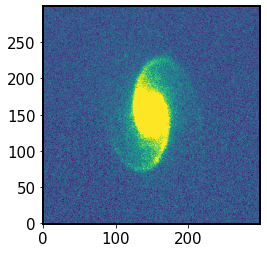

In [57]:
data = exposure.image.array
xcen,ycen=2038,2000
xw,yw = 150,150
dataP = data[ycen-yw:ycen+yw,xcen-xw:xcen+xw]
zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(dataP)

plt.imshow(dataP, vmin=vmin, vmax=vmax, origin='lower')

### 1) Varying rotSkyPos, rotTelPos =0

rotSkyPos 0-->30-->60 (9010000 -->9013000---> 9016000) , with rotTelPos 0,  imparts no rotation of the diffraction spikes pattern whatsoever

postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123110002, ...}, sc=Exposure] (id=425a660b-2352-4111-a7c7-2b1408d524b7)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123110002}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123113000, ...}, sc=Exposure] (id=7e5b247a-3f34-44d3-8626-a97b388098fa)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123113000}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123116000, ...}, sc=Exposure] (id=6de1e76b-d106-46ae-b4b7-c01214f64e9c)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123116000}


Text(0.5, 0.98, 'rotTelPos=0')

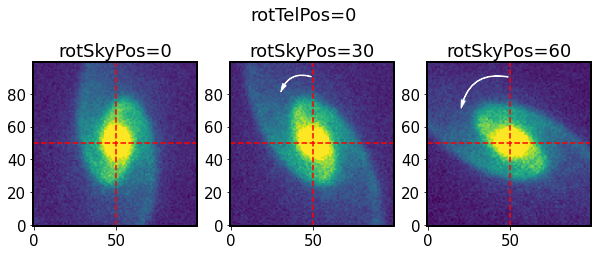

In [63]:
import matplotlib.patches as patches

# stars: 
# baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_d'
# obsIds [9010000,9013000,9016000]: 

baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_dg'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

# read in several exposures to illustrate
exposures = {}
for obsId in  [9010002,9013000,9016000]: #[9010000,9013000,9016000]:
    collection = f'ts_phosim_{obsId}'
    datasetRefs = butler.registry.queryDatasets(
                    datasetType="postISRCCD", collections=[collection]
               )
    for dataset in datasetRefs:
        print(dataset)
    dataId = {
                "instrument": dataset.dataId["instrument"],
                "detector": dataset.dataId["detector"],
                "exposure": dataset.dataId["exposure"],
            }
    print(dataId)
    exposure = butler.get( "postISRCCD", dataId=dataId,  collections=[collection])
    exposures[obsId]=exposure

#https://stackoverflow.com/questions/44526103/matplotlib-draw-curved-arrow-that-looks-just-like-pyplot-arrow
fig,ax = plt.subplots(1,3,figsize=(10,4))
xcen,ycen=2036,2000
xw,yw = 50,50 
zscale = ZScaleInterval()

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="w")
    
i=0
for key in exposures.keys():
    exposure = exposures[key]
    data = exposure.image.array
    dataP = data[ycen-yw:ycen+yw,xcen-xw:xcen+xw]
    vmin, vmax = zscale.get_limits(dataP)
    ax[i].imshow(dataP, vmin=vmin, vmax=vmax, origin='lower')
    ax[i].axhline(50,ls='--',c='r')
    ax[i].axvline(50,ls='--',c='r')
    i+=1

ax[0].set_title('rotSkyPos=0')    
arrow = patches.FancyArrowPatch((50,90), (30,80),
                         connectionstyle="arc3,rad=.5", **kw)
ax[1].add_patch(arrow)
ax[1].set_title('rotSkyPos=30')

arrow = patches.FancyArrowPatch((50,90), (20,70),
                         connectionstyle="arc3,rad=.5", **kw)
ax[2].set_title('rotSkyPos=60')
ax[2].add_patch(arrow)

fig.suptitle('rotTelPos=0', fontsize=18)

Text(0.5, 0.98, 'rotTelPos=0')

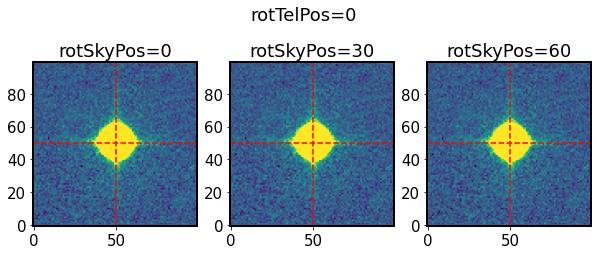

### 2) Varying rotTelPos, rotSkyPos = 0

postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123110002, ...}, sc=Exposure] (id=425a660b-2352-4111-a7c7-2b1408d524b7)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123110002}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123120030, ...}, sc=Exposure] (id=ec5f8f43-08a1-4633-aa0b-a6483193ab38)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123120030}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123120060, ...}, sc=Exposure] (id=1bcd79a9-6128-41eb-9e60-8b41af86dd88)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123120060}


Text(0.5, 0.98, 'rotSkyPos=0')

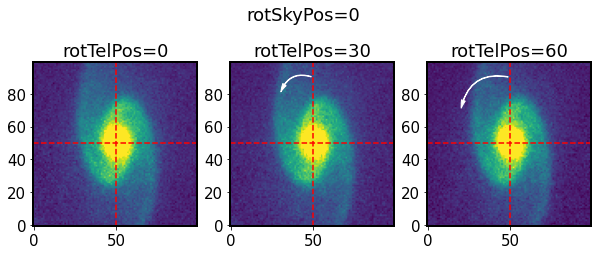

In [65]:
import matplotlib.patches as patches

#baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_d'
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_dg'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

# read in several exposures to illustrate
exposures = {}
for obsId in [9010002,9020030,9020060]:#[9010000,9020030,9020060]:
    collection = f'ts_phosim_{obsId}'
    datasetRefs = butler.registry.queryDatasets(
                    datasetType="postISRCCD", collections=[collection]
               )
    for dataset in datasetRefs:
        print(dataset)
    dataId = {
                "instrument": dataset.dataId["instrument"],
                "detector": dataset.dataId["detector"],
                "exposure": dataset.dataId["exposure"],
            }
    print(dataId)
    exposure = butler.get( "postISRCCD", dataId=dataId,  collections=[collection])
    exposures[obsId]=exposure
    
#https://stackoverflow.com/questions/44526103/matplotlib-draw-curved-arrow-that-looks-just-like-pyplot-arrow

fig,ax = plt.subplots(1,3,figsize=(10,4))
xcen,ycen=2036,2000
xw,yw = 50,50 
zscale = ZScaleInterval()

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="w")
    
    
i=0
for key in exposures.keys():
    exposure = exposures[key]
    data = exposure.image.array
    dataP = data[ycen-yw:ycen+yw,xcen-xw:xcen+xw]
    vmin, vmax = zscale.get_limits(dataP)
    ax[i].imshow(dataP, vmin=vmin, vmax=vmax, origin='lower')
    ax[i].axhline(50,ls='--',c='r')
    ax[i].axvline(50,ls='--',c='r')
    i+=1

ax[0].set_title('rotTelPos=0')    
arrow = patches.FancyArrowPatch((50,90), (30,80),
                         connectionstyle="arc3,rad=.5", **kw)
ax[1].add_patch(arrow)
ax[1].set_title('rotTelPos=30')

arrow = patches.FancyArrowPatch((50,90), (20,70),
                         connectionstyle="arc3,rad=.5", **kw)
ax[2].set_title('rotTelPos=60')
ax[2].add_patch(arrow)

fig.suptitle('rotSkyPos=0', fontsize=18)

Text(0.5, 0.98, 'rotSkyPos=0')

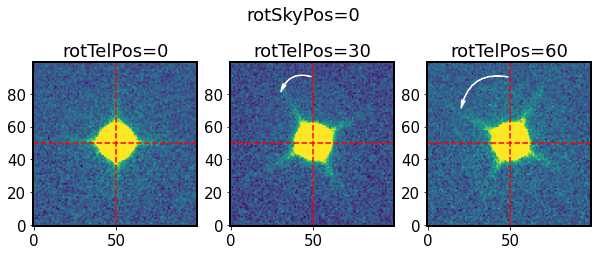

rotSkyPos 0, with rotTelPos 0 --> 30 --> 60 (9010000 --> 9020030 --> 9020060) , imparts rotation of the diffraction spikes to the left (counterclockwise)

## 3) No rotSkyPos, vary rotTelPos

postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123130000, ...}, sc=Exposure] (id=a098f4d4-ed75-4d9a-9723-37c0fa7affb7)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123130000}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123130030, ...}, sc=Exposure] (id=eeee0a19-8912-4c83-85a7-6625c136f129)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123130030}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123130060, ...}, sc=Exposure] (id=682b337f-0d7d-4a67-91e2-255f6175bcc6)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123130060}


Text(0.5, 0.98, 'no rotSkyPos')

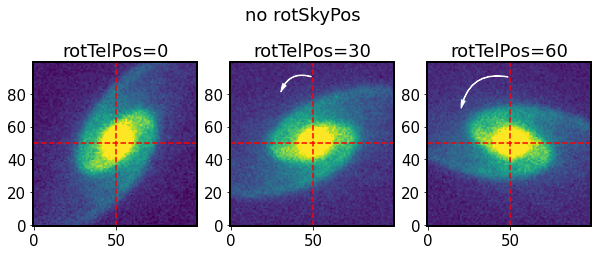

In [67]:
#baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_d'
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_dg'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

# read in several exposures to illustrate
exposures = {}
for obsId in [9030000,9030030,9030060]:
    collection = f'ts_phosim_{obsId}'
    datasetRefs = butler.registry.queryDatasets(
                    datasetType="postISRCCD", collections=[collection]
               )
    for dataset in datasetRefs:
        print(dataset)
    dataId = {
                "instrument": dataset.dataId["instrument"],
                "detector": dataset.dataId["detector"],
                "exposure": dataset.dataId["exposure"],
            }
    print(dataId)
    exposure = butler.get( "postISRCCD", dataId=dataId,  collections=[collection])
    exposures[obsId]=exposure
    
#https://stackoverflow.com/questions/44526103/matplotlib-draw-curved-arrow-that-looks-just-like-pyplot-arrow

fig,ax = plt.subplots(1,3,figsize=(10,4))
xcen,ycen=2036,2000
xw,yw = 50,50
zscale = ZScaleInterval()

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="w")
    
    
i=0
for key in exposures.keys():
    exposure = exposures[key]
    data = exposure.image.array
    dataP = data[ycen-yw:ycen+yw,xcen-xw:xcen+xw]
    vmin, vmax = zscale.get_limits(dataP)
    ax[i].imshow(dataP, vmin=vmin, vmax=vmax, origin='lower')
    ax[i].axhline(50,ls='--',c='r')
    ax[i].axvline(50,ls='--',c='r')
    i+=1

ax[0].set_title('rotTelPos=0')    
arrow = patches.FancyArrowPatch((50,90), (30,80),
                         connectionstyle="arc3,rad=.5", **kw)
ax[1].add_patch(arrow)
ax[1].set_title('rotTelPos=30')

arrow = patches.FancyArrowPatch((50,90), (20,70),
                         connectionstyle="arc3,rad=.5", **kw)
ax[2].set_title('rotTelPos=60')
ax[2].add_patch(arrow)

fig.suptitle('no rotSkyPos',fontsize=18)

In [ ]:
w/o rotSkyPos,  it is calculated based on rotTelPos, so that 

    rotSkyPos = parallactic - rotTelPos

First,  `rs-_rt-0/img/focus/starFocusPhosim.log`, rotSkyPos = 139.956581 = 139.956581 - 0
Second, `rs-_rt-30/img/focus/starFocusPhosim.log`, rotSkyPos = 109.956581 = 139.956581 - 30
Third,  `rs-_rt-30/img/focus/starFocusPhosim.log`, rotSkyPos = 79.956581 = 139.956581 - 60

Text(0.5, 0.98, 'no rotSkyPos')

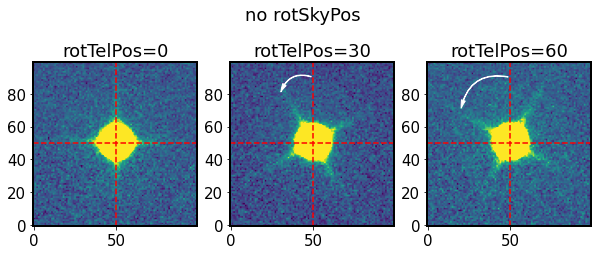

No rotSkyPos, with rotTelPos 0 --> 30 --> 60 (9010000 --> 9020030 --> 9020060) , imparts rotation of the diffraction spikes to the left (counterclockwise). So there appears to be no difference whether there is `rotSkyPos` or there isn't. 

## 4) Vary rotSkyPos,  no rotTelPos 

postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123140000, ...}, sc=Exposure] (id=1ca4134b-f662-4159-a7ca-41e813564f66)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123140000}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123143000, ...}, sc=Exposure] (id=efc3f3e7-1055-489b-aede-d1f4d6d5cf57)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123143000}
postISRCCD@{instrument: 'LSSTComCam', detector: 4, exposure: 4021123146000, ...}, sc=Exposure] (id=85cdd4d3-a4ee-44f9-98cf-e5e4e3a93c42)
{'instrument': 'LSSTComCam', 'detector': 4, 'exposure': 4021123146000}


Text(0.5, 0.98, 'no rotTelPos')

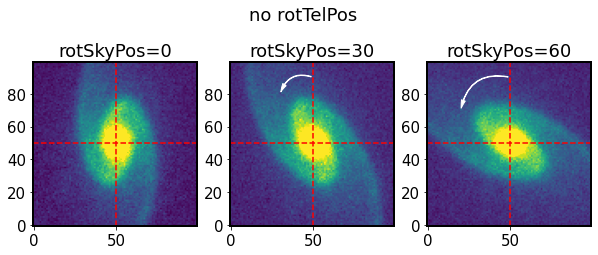

In [69]:
#baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_d'
baseOutputDir = '/project/scichris/aos/rotation_DM-34065/test02_dg'
butlerRootPath = os.path.join(baseOutputDir, "phosimData")
butler = dafButler.Butler(butlerRootPath)

# read in several exposures to illustrate
exposures = {}
for obsId in [9040000,9043000,9046000]:
    collection = f'ts_phosim_{obsId}'
    datasetRefs = butler.registry.queryDatasets(
                    datasetType="postISRCCD", collections=[collection]
               )
    for dataset in datasetRefs:
        print(dataset)
    dataId = {
                "instrument": dataset.dataId["instrument"],
                "detector": dataset.dataId["detector"],
                "exposure": dataset.dataId["exposure"],
            }
    print(dataId)
    exposure = butler.get( "postISRCCD", dataId=dataId,  collections=[collection])
    exposures[obsId]=exposure
    
#https://stackoverflow.com/questions/44526103/matplotlib-draw-curved-arrow-that-looks-just-like-pyplot-arrow
import matplotlib.patches as patches

fig,ax = plt.subplots(1,3,figsize=(10,4))
xcen,ycen=2036,2000
xw,yw = 50,50
zscale = ZScaleInterval()

style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="w")
    
    
i=0
for key in exposures.keys():
    exposure = exposures[key]
    data = exposure.image.array
    dataP = data[ycen-yw:ycen+yw,xcen-xw:xcen+xw]
    vmin, vmax = zscale.get_limits(dataP)
    ax[i].imshow(dataP, vmin=vmin, vmax=vmax, origin='lower')
    ax[i].axhline(50,ls='--',c='r')
    ax[i].axvline(50,ls='--',c='r')
    i+=1

ax[0].set_title('rotSkyPos=0')    
arrow = patches.FancyArrowPatch((50,90), (30,80),
                         connectionstyle="arc3,rad=.5", **kw)
ax[1].add_patch(arrow)
ax[1].set_title('rotSkyPos=30')

arrow = patches.FancyArrowPatch((50,90), (20,70),
                         connectionstyle="arc3,rad=.5", **kw)
ax[2].set_title('rotSkyPos=60')
ax[2].add_patch(arrow)

fig.suptitle('no rotTelPos')

Text(0.5, 0.98, 'no rotTelPos')

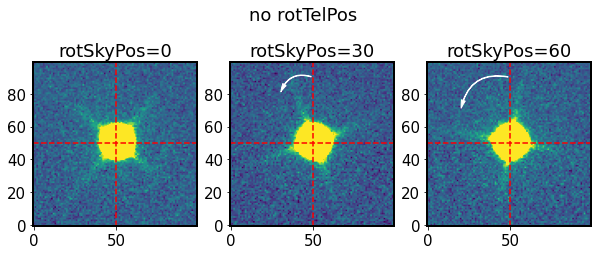

Here the results are most erratic. Why would it rotate once here and then another direction ? Probably because it calculates `rotTelPos` as a free parameter...

    rotSkyPos =  Parallactic - Rotator Angle
    
    i.e. rotSkyPos  = parallactic - rotTelPos, 
    or   rotTelPos  = parallactic - rotSkyPos 

First,  `rs-0_rt-/img/focus/starFocusPhosim.log ` rotTelPos = 139.956581 = parallactic angle 
Second, `rs-30_rt-/img/focus/starFocusPhosim.log`  rotTelPos = 109.956581 = 139.956581 - 30.0
Third,  `rs-60_rt-/img/focus/starFocusPhosim.log`  rotTelPos = 79.956581  = 139.956581 - 60.0

In [22]:
vmax

79.37656345171679